In [214]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.src.layers import GRU, Dropout, Dense
from keras.src.optimizers import Adam
from keras import Sequential, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from matplotlib import pyplot as plt
import joblib

In [215]:
def create_time_series(data, n_past):
    X, y = [], []
    for i in range(n_past, len(data)):
            X.append(data[i - n_past:i, 0:data.shape[1]])
            y.append(data[i,0])
    return np.array(X),np.array(y)

In [216]:
def create_model(train_input_shape):
    model = Sequential(name='GRU')
    optimizer = Adam(learning_rate=0.01)
    
    model.add(Input(shape=(train_input_shape.shape[1], train_input_shape.shape[2])))
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(32))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model

In [217]:
df = pd.read_csv('../data/processed/mbajk_dataset.csv')

In [218]:
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,available_bike_stands
0,2023-06-25 19:07:30+00:00,6.575747,264.602151,19.112706,9.911638,0.00000,0.0,4.685082e+129,8
1,2023-06-25 19:33:48+00:00,6.444121,246.135484,16.068919,9.508868,0.00000,0.0,4.727029e+129,7
2,2023-06-25 19:45:44+00:00,6.444121,246.135484,16.068919,9.508868,0.00000,0.0,4.727029e+129,6
3,2023-06-25 19:55:29+00:00,6.444121,246.135484,16.068919,9.508868,0.95361,0.0,4.727029e+129,8
4,2023-06-25 20:02:16+00:00,6.444121,246.135484,16.068919,9.508868,0.00000,0.0,4.727029e+129,12


In [219]:
window_size = 50

In [220]:
input_data = df.columns.tolist()
output_data = 'available_bike_stands'

input_data.remove(output_data)
input_data.remove('date')

In [221]:
ig_scores = mutual_info_regression(df[input_data], df[output_data])

feature_scores = pd.DataFrame({'Feature': df[input_data].columns, 'Information_Gain': ig_scores})
feature_scores = feature_scores.sort_values(by='Information_Gain', ascending=False)

feature_scores.reset_index(drop=True, inplace=True)
feature_scores.head()

,Feature,Information_Gain
0,surface_pressure,0.346338
1,apparent_temperature,0.345464
2,temperature,0.308738
3,dew_point,0.203231
4,precipitation_probability,0.140035


In [222]:
output_data = ['available_bike_stands']
for i in feature_scores['Feature'][:3].tolist():
    output_data.append(i)

In [223]:
input_columns = output_data
df[input_columns].head()

,available_bike_stands,surface_pressure,apparent_temperature,temperature
0,8,4.685082e+129,9.911638,6.575747
1,7,4.727029e+129,9.508868,6.444121
2,6,4.727029e+129,9.508868,6.444121
3,8,4.727029e+129,9.508868,6.444121
4,12,4.727029e+129,9.508868,6.444121


In [224]:
filtered_df = df[input_columns]
dataset = filtered_df.values

In [225]:
test_data_size = round(0.2 * len(dataset))

train_data = dataset[:-test_data_size]
test_data = dataset[-test_data_size:]

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (14954, 4)
Test data shape: (3738, 4)


In [226]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [227]:
X_train, y_train = create_time_series(train_data, window_size)
X_test, y_test = create_time_series(test_data, window_size)

In [228]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (14904, 50, 4)
Shape of X_test: (3688, 50, 4)
Shape of y_train: (14904,)
Shape of y_test: (3688,)


In [229]:
model = create_model(X_train)

In [230]:
hist = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - loss: 0.1053 - val_loss: 0.0063
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 4/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 5/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 6/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 7/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 8/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 9/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 10/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.0027 - val_loss: 0.0043


In [231]:
predicted = model.predict(X_test, verbose=0)

In [232]:
predicted_copy_array = np.repeat(predicted, len(input_columns), axis=-1)
predicted_copy_array.shape

(3688, 4)

In [ ]:
pred = scaler.inverse_transform(np.reshape(predicted_copy_array,(len(predicted), len(input_columns))))[:,0]
actual_copy_array = np.repeat(y_test, len(input_columns), axis=-1)
actual = scaler.inverse_transform(np.reshape(actual_copy_array,(len(y_test), len(input_columns))))[:,0]

In [234]:
mse = mean_squared_error(actual, pred)
mae = mean_absolute_error(actual, pred)
evs = explained_variance_score(actual, pred)

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'EVS: {evs:.2f}')

MSE: 2.04
MAE: 0.94
EVS: 0.96


In [235]:
dates = df['date'].values

output_df = {
    'Date': dates[-test_data_size + window_size:],
    'True': actual,
    'Predicted': pred
}

output_df = pd.DataFrame(output_df)
output_df.head(10)

,Date,True,Predicted
0,2023-09-15 06:43:51+00:00,18.0,18.692228
1,2023-09-15 06:53:58+00:00,19.0,18.713921
2,2023-09-15 06:56:30+00:00,18.0,19.517075
3,2023-09-15 07:04:07+00:00,20.0,18.722025
4,2023-09-15 07:08:45+00:00,21.0,20.154274
5,2023-09-15 07:14:16+00:00,21.0,20.951529
6,2023-09-15 07:17:40+00:00,20.0,21.040405
7,2023-09-15 07:24:21+00:00,20.0,20.402601
8,2023-09-15 07:34:27+00:00,20.0,20.325298
9,2023-09-15 07:37:53+00:00,18.0,20.324326


In [236]:
def line_plot(plot_out_df):
    plt.figure(figsize=(12, 8))
    plt.plot(plot_out_df['Date'], plot_out_df['True'], label='True')
    plt.plot(plot_out_df['Date'], plot_out_df['Predicted'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Available Bike Stands')
    plt.title('Actual vs Predicted values')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [237]:
def loss_line_plot():
    plt.figure(figsize=(16, 6))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

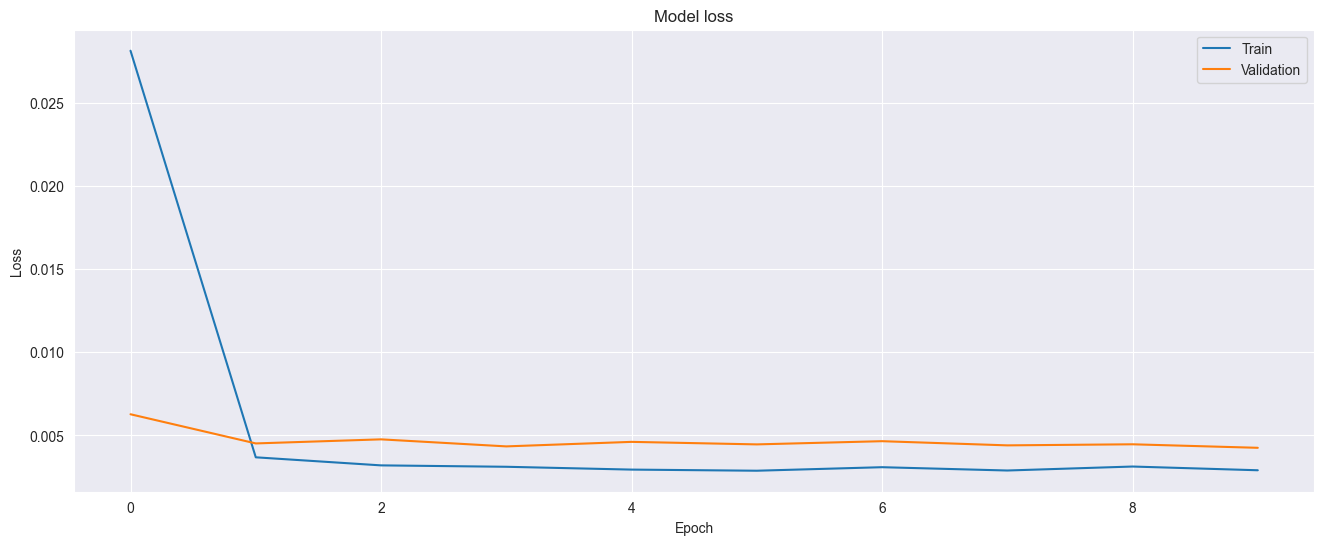

In [238]:
loss_line_plot()

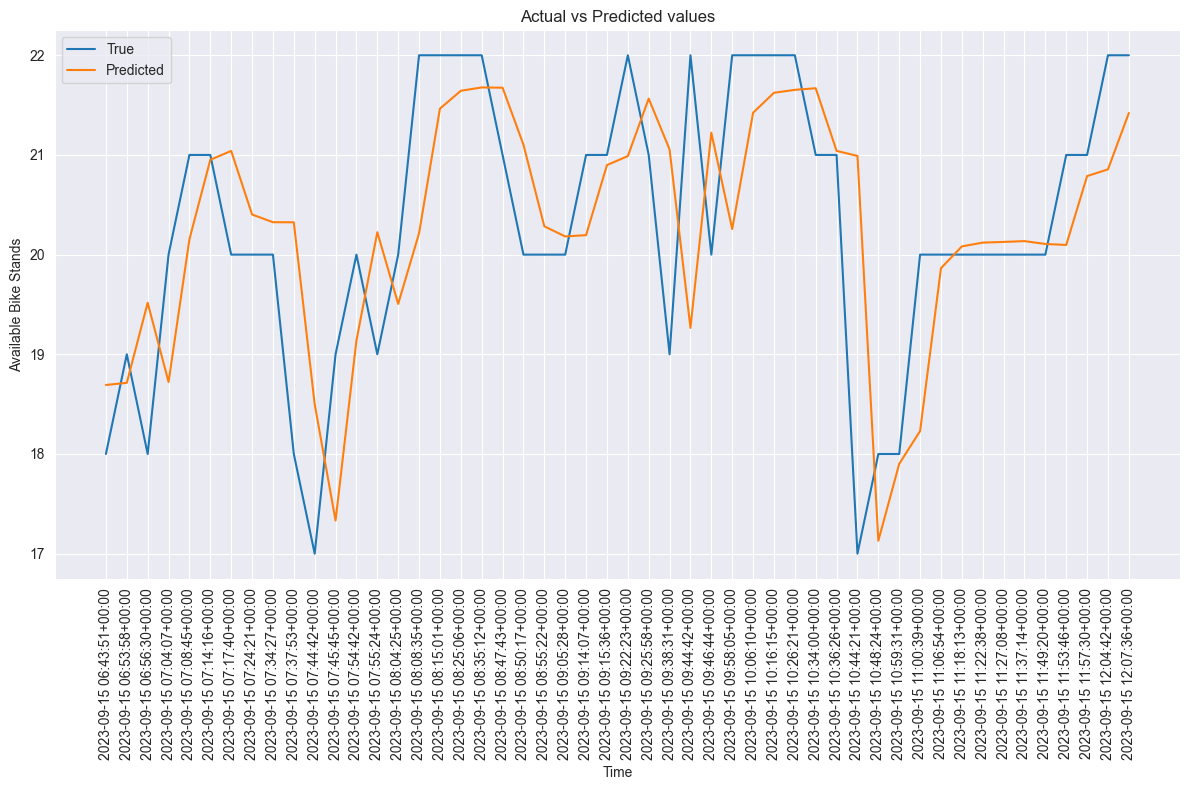

In [239]:
line_plot(output_df.head(50))

In [ ]:
joblib.dump(scaler, "../models/min_max_scaler.gz")

In [240]:
model.save(f"../models/mbajk_{model.name}.keras")